In [2]:
from turtle import st
import transbigdata as tbd
import networkx as nx
import pandas as pd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import ast
from multiprocessing import Pool
from itertools import islice
import math

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = 'SimSun'  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

line = pd.read_pickle('line.pkl')
stop = pd.read_pickle('stop.pkl')

#调整站名和地铁线路名
stop.loc[stop['line'] == '地铁4号线内圈', 'line'] = '地铁4号线'
stop.loc[stop['line'] == '地铁4号线外圈', 'line'] = '地铁4号线'
line.loc[line['line'] == '地铁4号线内圈', 'line'] = '地铁4号线'
line.loc[line['line'] == '地铁4号线外圈', 'line'] = '地铁4号线'
stop.loc[stop['line'] == '地铁2号线西延线', 'line'] = '地铁2号线'
line.loc[line['line'] == '地铁2号线西延线', 'line'] = '地铁2号线'
stop.loc[stop['linename'] == '地铁2号线西延线(徐泾东-蟠祥路)', 'linename'] = '地铁2号线(徐泾东-蟠祥路)'
stop.loc[stop['linename'] == '地铁2号线西延线(蟠祥路-徐泾东)', 'linename'] = '地铁2号线(蟠祥路-徐泾东)'
line.loc[line['linename'] == '地铁2号线西延线(徐泾东-蟠祥路)', 'linename'] = '地铁2号线(徐泾东-蟠祥路)'
line.loc[line['linename'] == '地铁2号线西延线(蟠祥路-徐泾东)', 'linename'] = '地铁2号线(蟠祥路-徐泾东)'
stop.loc[stop['line'] == '地铁13号线西延伸', 'line'] = '地铁13号线'
line.loc[line['line'] == '地铁13号线西延伸', 'line'] = '地铁13号线'
stop.loc[stop['linename'] == '地铁13号线西延伸(金运路-诸光路)', 'linename'] = '地铁13号线(金运路-诸光路)'
stop.loc[stop['linename'] == '地铁13号线西延伸(诸光路-金运路)', 'linename'] = '地铁13号线(诸光路-金运路)'
line.loc[line['linename'] == '地铁13号线西延伸(金运路-诸光路)', 'linename'] = '地铁13号线(金运路-诸光路)'
line.loc[line['linename'] == '地铁13号线西延伸(诸光路-金运路)', 'linename'] = '地铁13号线(诸光路-金运路)'
stop.loc[stop['line'] == '地铁17号线西延线', 'line'] = '地铁17号线'
line.loc[line['line'] == '地铁17号线西延线', 'line'] = '地铁17号线'
stop.loc[stop['linename'] == '地铁17号线西延线(西岑-东方绿舟)', 'linename'] = '地铁17号线(西岑-东方绿舟)'
stop.loc[stop['linename'] == '地铁17号线西延线(东方绿舟-西岑)', 'linename'] = '地铁17号线(东方绿舟-西岑)'
line.loc[line['linename'] == '地铁17号线西延线(西岑-东方绿舟)', 'linename'] = '地铁17号线(西岑-东方绿舟)'
line.loc[line['linename'] == '地铁17号线西延线(东方绿舟-西岑)', 'linename'] = '地铁17号线(东方绿舟-西岑)'
stop.loc[stop['line'] == '地铁18号线二期', 'line'] = '地铁18号线'
line.loc[line['line'] == '地铁18号线二期', 'line'] = '地铁18号线'
stop.loc[stop['linename'] == '地铁18号线二期(大康路-长江南路)', 'linename'] = '地铁18号线(大康路-长江南路)'
stop.loc[stop['linename'] == '地铁18号线二期(长江南路-大康路)', 'linename'] = '地铁18号线(长江南路-大康路)'
line.loc[line['linename'] == '地铁18号线二期(大康路-长江南路)', 'linename'] = '地铁18号线(大康路-长江南路)'
line.loc[line['linename'] == '地铁18号线二期(长江南路-大康路)', 'linename'] = '地铁18号线(长江南路-大康路)'


#构建地铁网络拓扑图
def split_subwayline(line, stop):
    def getline(r2, line_geometry):
        ls = []
        if r2['o_project'] <= r2['d_project']:
            tmp1 = np.linspace(r2['o_project'], r2['d_project'], 10)
        if r2['o_project'] > r2['d_project']:
            tmp1 = np.linspace(  # pragma: no cover
                r2['o_project'] - line_geometry.length, r2['d_project'], 10)
            tmp1[tmp1 < 0] = tmp1[tmp1 < 0] + line_geometry.length  # pragma: no cover
        for j in tmp1:
            ls.append(line_geometry.interpolate(j))
        return LineString(ls)

    lss = []
    for k in range(len(line)):
        r = line.iloc[k]
        line_geometry = r['geometry']
        tmp = stop[stop['linename'] == r['linename']].copy()
        for i in tmp.columns:
            tmp[i + '1'] = tmp[i].shift(-1)
        tmp = tmp.iloc[:-1]
        tmp = tmp[['stationnames', 'stationnames1',
                   'geometry', 'geometry1', 'linename', 'line']]
        tmp['o_project'] = tmp['geometry'].apply(
            r['geometry'].project)
        tmp['d_project'] = tmp['geometry1'].apply(
            r['geometry'].project)
        tmp['geometry'] = tmp.apply(
            lambda r2: getline(r2, line_geometry), axis=1)
        lss.append(tmp)
    metro_line_splited = pd.concat(lss).drop('geometry1', axis=1)
    metro_line_splited.crs = 'epsg:4326'
    metro_line_splited['length'] = metro_line_splited.to_crs(epsg=3857).length
    metro_line_splited = metro_line_splited.drop(
        ['o_project', 'd_project'], axis=1)
    return metro_line_splited


def metro_network(line, stop, transfertime=5, nxgraph=True):
    # Obtain edge1: Network edge for line section.
    linestop = stop.copy()
    if ('speed' not in line.columns) | ('stoptime' not in line.columns):
        raise ValueError(  # pragma: no cover
            'Lines should have `line` column to store line name,'
            '`speed` column to store metro speed and'
            '`stoptime` column to store stop time at each station'
        )
    for i in linestop.columns:
        linestop[i + '1'] = linestop[i].shift(-1)
    linestop = linestop[linestop['linename'] == linestop['linename1']].copy()
    linestop = linestop.rename(
        columns={'stationnames': 'ostop', 'stationnames1': 'dstop'})
    linestop['ostation'] = linestop['line'] + linestop['ostop']
    linestop['dstation'] = linestop['line'] + linestop['dstop']
    edge1 = linestop[['ostation', 'dstation']].copy()

    # calculate travel time for edge1
    # calculate distance
    metrolinesplit = split_subwayline(line, stop)
    metrolinesplit['ostation'] = metrolinesplit['line'] + \
                                 metrolinesplit['stationnames']
    metrolinesplit['dstation'] = metrolinesplit['line'] + \
                                 metrolinesplit['stationnames1']
    metrolinesplit = metrolinesplit[['ostation', 'dstation', 'line', 'length']]
    edge1 = pd.merge(edge1, metrolinesplit, how='left')
    edge1 = pd.merge(edge1, line[['line', 'speed', 'stoptime']])

    # calculate duration
    edge1['duration'] = 60 * (edge1['length'] / 1000) / \
                        edge1['speed'] + edge1['stoptime']
    edge1 = edge1[['ostation', 'dstation', 'duration']].drop_duplicates(
        subset=['ostation', 'dstation'])

    # Obtain edge2: Network edge for transfering.
    linestop = stop.copy()
    linestop['station'] = linestop['line'] + linestop['stationnames']
    tmp = linestop.groupby(['stationnames'])[
        'linename'].count().rename('count').reset_index()
    tmp = pd.merge(linestop, tmp[tmp['count'] > 2]
    ['stationnames'], on='stationnames')
    tmp = tmp[['stationnames', 'line', 'station']].drop_duplicates()
    tmp = pd.merge(tmp, tmp, on='stationnames')

    edge2 = tmp[tmp['line_x'] != tmp['line_y']][['station_x', 'station_y']]
    # All transfer time are set as the same, export `edge2` for further degign
    edge2['duration'] = transfertime
    edge2.columns = edge1.columns
    edge = pd.concat([edge1, edge2])
    node = list(edge['ostation'].drop_duplicates())
    if nxgraph:
        import networkx as nx
        G = nx.Graph()
        G.add_nodes_from(node)
        G.add_weighted_edges_from(edge.values)
        return G
    else:
        return edge1, edge2, node  # pragma: no cover


line['speed'] = 37.3  #地铁运行速度 km/h
line['stoptime'] = 0.3  #停站时间 min

G = metro_network(line, stop, transfertime=5, nxgraph=True)

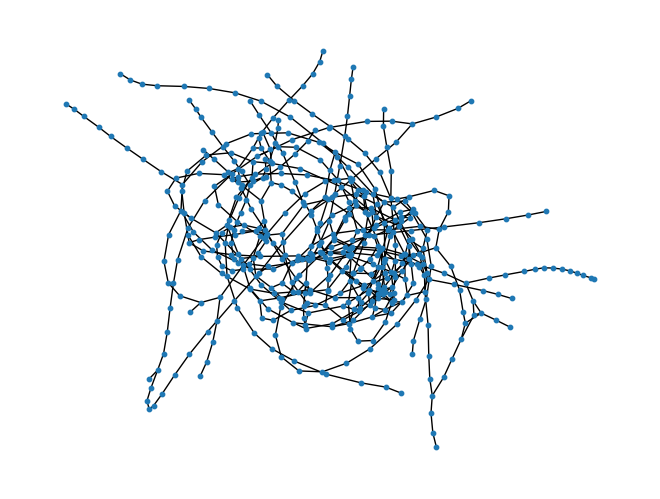

In [3]:
nx.draw(G,node_size = 10)

<Axes: >

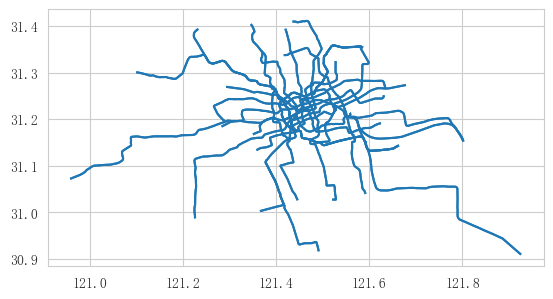

In [4]:
line.plot()

In [5]:
# K短路算法
def get_k_shortest_paths(G, lineostation, linedstation, k):
    return list(
        islice(nx.shortest_simple_paths(G, lineostation, linedstation, weight='weight'), k)
    )


#计算路径的在车时间
def get_path_traveltime(G, path):
    traveltime = 0
    for i in range(len(path) - 1):
        traveltime += G.get_edge_data(path[i], path[i + 1])['weight']
    return traveltime

# 计算换乘次数 
def get_transfer_count(path):
    transfer_count = 0
    for i in range(1, len(path)):
        # 如果当前站点和前一个站点的线路不同，则换乘次数加一
        if path[i].split('线')[0] != path[i-1].split('线')[0]:
            transfer_count += 1
    return transfer_count

def verify_path(paths):
    dropindex=[]
    #paths= ast.literal_eval(paths)
    for j in range(len(paths)):        
        path = paths[j]
#计算换乘次数和去除无效路径
        used_lines = set()
        used_lines.add(path[0].split('线')[0])
        repeated_lines = set()
        for s in range(len(path)-1):
            if path[s].split('线')[0] != path[s+1].split('线')[0] :#判断是否换乘
                if path[s+1].split('线')[0] in used_lines:# 检查线路是否已经使用过
                    repeated_lines.add(path[s+1].split('线')[0])# 如果已使用过，记录为重复线路
                else:
                    used_lines.add(path[s+1].split('线')[0])# 如果是第一次使用，添加到已使用的线路集合中
        transfercount = len(used_lines)-1
        if len(repeated_lines) != 0 or transfercount >=5: #删除有重复线路的路径\换乘次数大于5的路径
            dropindex.append(j)
    paths = [element for index, element in enumerate(paths) if index not in dropindex]
    return paths
#更新客流表
def update_flow(ls,passenger_flow):
    ls = pd.concat(ls)
    flow = ls.groupby(['o','d'])['volume'].sum().reset_index()
    flow = pd.merge(passenger_flow,flow ,on=['o','d'],suffixes=('_df1', '_df2'),how='left')
    flow['volume_df2'].fillna(0,inplace=True)
    flow['volume']=flow['volume_df2']+flow['volume_df1']
    flow.drop(columns=['volume_df1','volume_df2'],inplace=True)
    return flow
#计算拥挤度
def get_congestion(path,passenger_flow):    
    tmp = pd.DataFrame(path,columns=['o'])
    tmp['d'] = tmp['o'].shift(-1)
    tmp = tmp.iloc[:-1]
    flow = pd.merge(tmp,passenger_flow,on=['o','d'],how='left')['volume'].sum()
    rate = flow/(capacity*len(path))
    if rate <= 0.7:
        congestion = 0
    elif rate <= 1:
        congestion = alpha*(rate-0.7)
    else:
        congestion = alpha*(1-0.7)+beta*(rate-1)
    return congestion
#计算出行阻抗
def get_cost(path,congestion):
    transfercount = get_transfer_count(path)
    f1 = get_path_traveltime(G,path) - transfercount*transfertime #在车时间
    f2 = transfercount*transfertime #换乘时间
    f3 = metrogap*0.5+intime+outtime #进出站时间加候车时间
    fee = f1*(1+congestion) + f2 + f3 
    return fee

In [7]:
#读取数据{OD表（'ostation','dstation','volume')，客流表('o','d','volume')}
#读取OD
OD = pd.read_csv('OD2_paths.csv')
#先取1w条数据做测试
#读取客流表
passenger_flow = pd.read_csv('passenger_flow.csv')
passenger_flow['volume']=0#流量归零
#需要的参数
#拥挤度
alpha=1.1
beta=1.5
#出行阻抗
metrogap=3 #地铁发车间隔
capacity=(60/metrogap)*310*6#一小时内区间满载定员
transfertime=5 #换乘时间
intime = 5 #进站时间
outtime = 5 #出站时间
#logit模型
theta = 2.18
congestion = 0
sumfee=0#乘客广义出行费用之和

In [9]:
OD['paths'] = OD['paths'].apply(ast.literal_eval)

In [8]:
OD.sort_values(by=['volume'], ascending=False)

,ostation,dstation,volume,paths
101486,地铁9号线漕河泾开发区,地铁9号线泗泾,2702.0,"[['地铁9号线漕河泾开发区', '地铁9号线合川路', '地铁9号线星中路', '地铁9号..."
101485,地铁9号线漕河泾开发区,地铁9号线佘山,1804.0,"[['地铁9号线漕河泾开发区', '地铁9号线合川路', '地铁9号线星中路', '地铁9号..."
101484,地铁9号线金吉路,地铁9号线曹路,1762.0,"[['地铁9号线金吉路', '地铁9号线金海路', '地铁9号线顾唐路', '地铁9号线民雷..."
101483,地铁9号线漕河泾开发区,地铁9号线九亭,1746.0,"[['地铁9号线漕河泾开发区', '地铁9号线合川路', '地铁9号线星中路', '地铁9号..."
101482,地铁2号线金科路,地铁2号线川沙,1229.0,"[['地铁2号线金科路', '地铁2号线广兰路', '地铁2号线唐镇', '地铁2号线创新中..."
...,...,...,...,...
17563,地铁6号线外高桥保税区南,地铁16号线华夏中路,1.0,"[['地铁6号线外高桥保税区南', '地铁6号线洲海路', '地铁6号线五洲大道', '地铁..."
17564,地铁3号线铁力路,地铁8号线曲阜路,1.0,"[['地铁3号线铁力路', '地铁3号线友谊路', '地铁3号线宝杨路', '地铁3号线水产..."
17565,地铁2号线北新泾,地铁7号线南陈路,1.0,"[['地铁2号线北新泾', '地铁2号线威宁路', '地铁2号线娄山关路', '地铁2号线中..."
17566,地铁7号线杨高南路,地铁9号线蓝天路,1.0,"[['地铁7号线杨高南路', '地铁7号线锦绣路', '地铁7号线芳华路', '地铁7号线龙..."


In [24]:
def assignment(OD,passenger_flow,part):
    ls = []
    lenght = len(OD)
    for i in tqdm(range(lenght),position=0):
        r=OD.iloc[i]
        cost = []
    #计算出行阻抗
        for z in range(len(r['paths'])):
            path = r['paths'][z]
            congestion = get_congestion(path,passenger_flow)
            fee = get_cost(path,congestion)
            cost.append(fee)
    #分配客流
        probabilities = []
        cost = np.array(cost)
        cost = cost/60
        probability = np.exp(-theta *cost) / np.sum(np.exp(-theta* cost))
        probabilities=list(probability)
    #更新客流表
        for x, path in enumerate(r['paths']):
            tmp = pd.DataFrame(path, columns=['o'])
            tmp['d'] = tmp['o'].shift(-1)
            tmp = tmp.iloc[:-1]# 计算目的地，避免在循环中重复计算
            tmp['volume'] = int(r['volume'] * probability[x] * part)  # 计算分配的流量
            ls.append(tmp) 
    return ls

In [23]:
OD2=OD[OD['volume']>2]
ls1=assignment(OD2,passenger_flow,0.2)

100%|██████████| 60044/60044 [12:03<00:00, 82.98it/s] 


In [24]:
flow2 = update_flow(ls1,passenger_flow)

In [26]:
flow2.to_csv('flow2.csv')

In [27]:
OD3=OD[OD['volume']>1]
ls3=assignment(OD3,flow2,0.3)
flow3=update_flow(ls3,passenger_flow)
flow3.to_csv('flow3.csv')

100%|██████████| 75147/75147 [16:26<00:00, 76.14it/s]  


In [25]:
ls5=assignment(OD,flow,0.5)
flow5=update_flow(ls5,passenger_flow)
flow5.to_csv('flow5.csv',index=False)

100%|██████████| 101487/101487 [22:28<00:00, 75.28it/s] 


In [7]:
flow2 = pd.read_csv('flow2.csv')
flow3 = pd.read_csv('flow3.csv')

In [15]:
flow = pd.merge(flow2,flow3,on=['o','d'])

In [17]:
flow['volume']=flow['volume_x']+flow['volume_y']


In [27]:
flow = pd.merge(flow,flow5,on=['o','d'])

In [29]:
flow['volume']=flow['volume_x']+flow['volume_y']

In [31]:
flow.drop(columns=['volume_x','volume_y'],inplace=True)

In [33]:
flow.to_csv('flow.csv',index=False)

In [3]:
flow = pd.read_csv('flow.csv')

In [5]:
flow.to_csv('区间断面客流.csv',index=False,encoding='gbk')